<a href="https://colab.research.google.com/github/kbatbouta/Senior/blob/master/MoveFaceLSTMv0_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DRIVE SETUP

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()

gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
from google.colab import drive
from os import listdir

if 'gdrive' not in listdir("/"):
    # To determine which version you're using:
    !pip show tensorflow

    # For the current version: 
    !pip install tensorflow==2.0.0-alpha0 
    
    # mounting  drive: 
    drive.mount('/gdrive')

In [0]:
import random as rand

# DLIB START

In [0]:
import matplotlib
%matplotlib inline

from matplotlib import pyplot as plt
from IPython import display

import cv2

import numpy as np
import scipy as sp

import pandas as pd

if "sys" not in locals():
    import sys    

if "dlib" not in sys.modules:    
    if "output" not in locals():
        from google import colab
        from google.colab import output
        from google.colab import widgets
        
        !wget https://github.com/italojs/facial-landmarks-recognition-/raw/master/shape_predictor_68_face_landmarks.dat
    
    if "cv2" not in locals():
        import cv2
            
    !pip install dlib imutils
    output.clear()
    
from imutils import face_utils
import dlib   

p = "./shape_predictor_68_face_landmarks.dat"
face_detector = dlib.get_frontal_face_detector()
face_predictor = dlib.shape_predictor(p)

In [0]:
import time, sys
from IPython.display import clear_output

def update_progress(progress, msg='Progress'):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text =  msg + ": [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

# UTILS!!

In [0]:
import json
from IPython.display import JSON

import uuid
from IPython.display import display_javascript, display_html, display
import json

class RenderJSON(object):
    def __init__(self, json_data):
        if isinstance(json_data, dict):
            self.json_str = json.dumps(json_data)
        else:
            self.json_str = json_data
        self.uuid = str(uuid.uuid4())

    def _ipython_display_(self):
        display_html('<div id="{}" style="height: 600px; width:100%;"></div>'.format(self.uuid), raw=True)
        display_javascript("""
        require(["https://rawgit.com/caldwell/renderjson/master/renderjson.js"], function() {
        document.getElementById('%s').appendChild(renderjson(%s))
        });
        """ % (self.uuid, self.json_str), raw=True)


In [0]:
def getLandmarks(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detections = face_detector(gray)

    assert len(detections) != 0

    shape = face_predictor(gray, detections[0])
    pts = face_utils.shape_to_np(shape)

    pts = np.array(pts.tolist() + [(int((pts[39][0] + pts[27][0])/ 2),
                                    int((pts[39][1] + pts[27][1])/ 2)),
             (int((pts[42][0] + pts[27][0])/ 2),
              int((pts[42][1] + pts[27][1])/ 2))], dtype=np.int32)
    
    assert len(pts) != 0
    return pts, face_utils.rect_to_bb(detections[0])

# define a dictionary that maps the indexes of the facial
# landmarks to specific face regions
FACIAL_LANDMARKS_IDXS = dict([
	("mouth", [np.arange(59, 47, -1).tolist() + [59], np.arange(67, 59, -1).tolist() + [67]]),
	("right_eyebrow", [np.arange(17, 22).tolist() + [17]]),
	("left_eyebrow", [np.arange(22, 27).tolist() + [22]]),
	("right_eye", [np.arange(36, 42).tolist() + [36]]),
	("left_eye", [np.arange(42, 48).tolist() + [42]]),
	("outer", [np.arange(0, 17).tolist() + np.arange(26, 16, -1).tolist() + [0]]),
    ("nose", [[30, 31, 32, 33, 34, 35, 30],
  [31, 30, 29, 28, 27, 68, 31],
  [27, 28, 29, 30, 35, 69, 27]])
])


def _drawChannel(pts, dsize=(720, 1280, 1)):
    canvs = np.zeros(dsize)
    return cv2.fillConvexPoly(canvs, pts, (1), lineType=16)


def _fillFace(pts, dsize=(720, 1280)):
    out = cv2.fillConvexPoly(np.zeros((dsize[0], dsize[1], 3)), pts[FACIAL_LANDMARKS_IDXS['outer'][0]].astype(np.int32), (1.0, 0.0, 0.0), lineType=16)
        
    out = cv2.fillConvexPoly(out, pts[FACIAL_LANDMARKS_IDXS['right_eye'][0]].astype(np.int32), (0.0, 1.0, 0.2), lineType=16)
    out = cv2.fillConvexPoly(out, pts[FACIAL_LANDMARKS_IDXS['left_eye'][0]].astype(np.int32), (0.0, 1.0, 0.1), lineType=16)

    out = cv2.fillConvexPoly(out, pts[FACIAL_LANDMARKS_IDXS['nose'][0]].astype(np.int32), (0.5, 0.0, 1.0), lineType=16)
    out = cv2.fillConvexPoly(out, pts[FACIAL_LANDMARKS_IDXS['nose'][1]].astype(np.int32), (0.2, 1.0, 0.0), lineType=16)
    out = cv2.fillConvexPoly(out, pts[FACIAL_LANDMARKS_IDXS['nose'][2]].astype(np.int32), (1.0, 0.0, 1.0), lineType=16)
    
    out = cv2.fillConvexPoly(out, pts[FACIAL_LANDMARKS_IDXS['mouth'][0]].astype(np.int32), (0.0, 1.0, 1.0), lineType=16)
    out = cv2.fillConvexPoly(out, pts[FACIAL_LANDMARKS_IDXS['mouth'][1]].astype(np.int32), (1.0, 0.5, 0.0), lineType=16)
    
    return out

def _getPuiple(imgs, pts):
    def _getPL(fk):
        eye_pts = pts[FACIAL_LANDMARKS_IDXS[fk][0]]
        bn = (eye_pts.T[0].min(), eye_pts.T[1].min(), eye_pts.T[0].max() - eye_pts.T[0].min(), eye_pts.T[1].max() - eye_pts.T[1].min())
        eye_patch = cv2.cvtColor(img[bn[1] - 5:bn[1] + bn[3] + 5, bn[0] - 5:bn[0] + 5 + bn[2]], cv2.COLOR_RGB2HSV)[:,:,2]

        eye_patch = cv2.medianBlur(eye_patch, int(min(list(eye_patch.shape[:2])) / 2) + int(min(list(eye_patch.shape[:2])) / 2) % 2 + 3)

        eye_patch.cumsum(axis=1).sum(axis=1).argmin()
        eye_patch.sum(axis=0).argmin()

        x = bn[1] + eye_patch.cumsum(axis=1).sum(axis=1).argmin()
        y = bn[0] + eye_patch.sum(axis=0).argmin()
        return y, x

    return (_getPL('left_eye'), _getPL('right_eye'))



def getMask(face, return_center=False):
    pts, bbox = getLandmarks(face)
    o_pts = (pts[:,0].min(), pts[:,1].min(), pts[:,0].max(), pts[:,1].max())
    
    pts[:,0] = pts[:,0] - pts.T[0].min()
    pts[:,1] = pts[:,1] - pts.T[1].min()

    mask = _fillFace(pts, face.shape[:2])
    mask = mask[:pts[:,1].max() + 4,:pts[:,0].max() + 4,:]
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    
    THICKNESS = int(max([int(((pts[27][0] - pts[30][0]) ** 2 + (pts[27][1] - pts[30][1]) ** 2) ** 0.5 / 8), 3.0]))
    
    eye_brow = np.zeros((pts[:,1].max() + 4, pts[:, 0].max() + 4, 3))
    
    mask = cv2.fillConvexPoly(mask, pts[FACIAL_LANDMARKS_IDXS['mouth'][0]].astype(np.int32), (0.25, 0.1, 0.25), lineType=16)
    mask = cv2.fillConvexPoly(mask, pts[FACIAL_LANDMARKS_IDXS['mouth'][1]].astype(np.int32), (0.0, 1.0, 0.5), lineType=16)

    for i in range(17, 20):        
        eye_brow = cv2.line(eye_brow, tuple(pts[i]),tuple(pts[i + 1]), color=(1.0, 0.5, 1.0), thickness=THICKNESS, lineType=16 ) 
    for i in range(22, 25):        
        eye_brow = cv2.line(eye_brow, tuple(pts[i]),tuple(pts[i + 1]), color=(1.0, 0.5, 1.0), thickness=THICKNESS, lineType=16 )   
        
    lips = np.zeros((pts[:,1].max() + 4, pts[:, 0].max() + 4, 3))
    for i in range(48, 54):        
        lips = cv2.line(lips, tuple(pts[i]),tuple(pts[i + 1]), color=(0.5, 0.0, 1.0), thickness=THICKNESS, lineType=16 ) 
    for i in np.arange(54, 58, 1).tolist():        
        lips = cv2.line(lips, tuple(pts[i]),tuple(pts[i + 1]), color=(0.0, 1.0, 1.0), thickness=THICKNESS, lineType=16 ) 
    cv2.line(lips, tuple(pts[58]),tuple(pts[48]), color=(1.0), thickness=THICKNESS, lineType=16 )     
    
    for i in np.arange(36, 41, 1).tolist():        
        mask = cv2.line(mask, tuple(pts[i]),tuple(pts[i + 1]), color=(0.0, 0.75, 1.0), thickness=THICKNESS, lineType=16 ) 
    mask = cv2.line(mask, tuple(pts[41]),tuple(pts[36]), color=(0.0, 0.75, 1.0), thickness=THICKNESS, lineType=16 ) 
    
    for i in np.arange(42, 47, 1).tolist():        
        mask = cv2.line(mask, tuple(pts[i]),tuple(pts[i + 1]), color=(0.0, 1.0, 0.64),
                        thickness=max([int(THICKNESS / 2), 1]), lineType=16 ) 
    mask = cv2.line(mask, tuple(pts[47]),tuple(pts[42]), color=(0.0, 1.0, 0.64),
                    thickness=max([int(THICKNESS / 2), 1]), lineType=16 ) 
    
    mask = mask + eye_brow
    mask = mask + lips
    
    a_face = face[o_pts[1]:o_pts[3], o_pts[0]:o_pts[2],:]    
    if not return_center:
        return np.abs(1 - (mask - mask.min()) / (mask.max() - mask.min())), a_face
    return np.abs(1 - (mask - mask.min()) / (mask.max() - mask.min())), a_face, ((o_pts[0] - o_pts[2]) / 2, (o_pts[1] - o_pts[3]) / 2)

In [0]:
def getPairs(imgs, return_centroid=False):
    def getLandmarks(img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        detections = face_detector(gray)

        assert len(detections) != 0

        rect = face_utils.rect_to_bb(detections[0])
        croped_detections = dlib.rectangle(0, 0, rect[3], rect[3])

        shape = face_predictor(img, croped_detections)
        pts = face_utils.shape_to_np(shape)

        LANDMARKS_CONSTENT = np.array([(int((pts[39][0] + pts[27][0])/ 2),
                                        int((pts[39][1] + pts[27][1])/ 2)),
                 (int((pts[42][0] + pts[27][0])/ 2),
                  int((pts[42][1] + pts[27][1])/ 2))], dtype=np.float32)
        pts = np.append(pts, LANDMARKS_CONSTENT, axis=0)

        assert len(pts) != 0
        return pts.astype(np.int32), (rect[0], rect[1], int(pts.T[0].max()), int(pts.T[1].max())), None

    # define a dictionary that maps the indexes of the facial
    # landmarks to specific face regions
    FACIAL_LANDMARKS_IDXS = dict([
        ("mouth", [np.arange(59, 47, -1).tolist() + [59], np.arange(67, 59, -1).tolist() + [67]]),
        ("right_eyebrow", [np.arange(17, 22).tolist() + [17]]),
        ("left_eyebrow", [np.arange(22, 27).tolist() + [22]]),
        ("right_eye", [np.arange(36, 42).tolist() + [36]]),
        ("left_eye", [np.arange(42, 48).tolist() + [42]]),
        ("outer", [np.arange(0, 17).tolist() +  np.arange(26, 16, -1).tolist()]),
        ("nose", [[30, 31, 32, 33, 34, 35, 30],
      [31, 30, 29, 28, 27, 68, 31],
      [27, 28, 29, 30, 35, 69, 27]])
    ])


    FACIAL_LANDMARKS_COLOR = [
        (1.0, 0.0, 0.0),
        (0.0, 1.0, 1.0),
        (0.0, 1.0, 1.0),
        (0.75, 0.0, 0.75),
        (0.75, 0.0, 0.75),
        (0.0, 1.0, 0.0),
        (1.0, 0.0, 1.0),
        (1.0, 1.0, 1.0),
        (0.5, 1.0, 0.0),
        (0.5, 0.0, 1.0),
    ]

    def _getMask(imgs, pts, rect):
        FACIAL_LANDMARKS_AREAS = [
            pts[tuple(FACIAL_LANDMARKS_IDXS['outer'])].astype(np.int32),
            pts[tuple(FACIAL_LANDMARKS_IDXS['left_eyebrow'])],
            pts[tuple(FACIAL_LANDMARKS_IDXS['right_eyebrow'])],
            pts[tuple(FACIAL_LANDMARKS_IDXS['left_eye'])],
            pts[tuple(FACIAL_LANDMARKS_IDXS['right_eye'])],
            pts[tuple([FACIAL_LANDMARKS_IDXS['mouth'][0]])],
            pts[tuple([FACIAL_LANDMARKS_IDXS['mouth'][1]])],

            pts[FACIAL_LANDMARKS_IDXS['nose'][0]],
            pts[FACIAL_LANDMARKS_IDXS['nose'][1]],
            pts[FACIAL_LANDMARKS_IDXS['nose'][2]]
        ]

        filledcanvs = np.zeros((imgs.shape[0], imgs.shape[1], 3))
        canvs = np.zeros((imgs.shape[0], imgs.shape[1], 3))

        for area, color in zip(FACIAL_LANDMARKS_AREAS, FACIAL_LANDMARKS_COLOR):
            cv2.fillPoly(canvs, [area], color)
        return canvs
    
    _, img, centroid = getMask(imgs, return_center=True)
    pts, rect, _ = getLandmarks(img)
    if return_centroid:
        return img, _getMask(img, pts, rect), centroid
    
    return img, _getMask(img, pts, rect)

In [0]:
def imshowGrid(dimgs, dgrid_shape, save=False, flip_channels=True):    
    from IPython import display
    
    imgs, gray = np.array(dimgs, dtype=np.float32), False
    if imgs.shape[-1] == 1 and len(imgs.shape) != 3:
        imgs, gray = imgs.reshape((imgs.shape[0], imgs.shape[1], imgs.shape[2])), True 
        
    if imgs.max() <= 1.0 and imgs.max() > -1.0 and imgs.max() != imgs.min():
        imgs = ((imgs - imgs.min()) / (imgs.max() - imgs.min()) * 255)
    imgs = imgs.astype(np.uint8)
    
    canves = None
    if not gray:
        canves = np.zeros((int(imgs.shape[1] * dgrid_shape[0]), int(imgs.shape[2] * dgrid_shape[1]), 3)).astype(np.uint8)
    else:
        canves = np.zeros((int(imgs.shape[1] * dgrid_shape[0]), int(imgs.shape[2] * dgrid_shape[1]))).astype(np.uint8)               
    for u in range(0, int(dgrid_shape[0])):
        for v in range(0, int(dgrid_shape[1])):
            U, dU, V, dV = int(imgs.shape[1] * u), int(imgs.shape[1] * (u + 1)), int(imgs.shape[2] * v), int(imgs.shape[2] * (v + 1))
            index = dgrid_shape[0] * v + u 
            canves[U:dU, V:dV] = imgs[index]

    if not gray:       
        if flip_channels:
            plt.imshow(cv2.cvtColor(canves, cv2.COLOR_RGB2BGR), interpolation='nearest')
            plt.axis('off')
            plt.show()
        else:
            plt.imshow(canves, interpolation='nearest')
            plt.axis('off')
            plt.show()
    else:
        plt.imshow(canves, 'gray', interpolation='nearest')
        plt.axis('off')
        plt.show()        
        
    display.display()
       
    if save is True:
        return canves
    
def logImgs(dimgs, to_drive=True, flip_channels=True):
    multi, imgs = type(dimgs) is list, None
    if not multi:
        multi = len(dimgs.shape) > 3 and dimgs.shape[-1] <= 3
        if dimgs.shape[-1] == 1:
            imgs = dimgs.reshape(dimgs.shape[:-1])  
        else:
            imgs = np.array([dimgs], dtype=np.float32)
    else:
        imgs = np.array([dimgs], dtype=np.float32)
    if len(imgs.shape) > 4:
        imgs = imgs.reshape(imgs.shape[1:])
    
    if imgs.max() <= 1.0 and imgs.max() > -1.0 and imgs.max() != imgs.min():
        imgs = ((imgs - imgs.min()) / (imgs.max() - imgs.min()) * 255)
    imgs = imgs.astype(np.uint8)
    
    if not path.exists(DRIVE_LOG_PATH):
        !mkdir /gdrive/My\ Drive/Senior
        !mkdir /gdrive/My\ Drive/Senior/images_logs
    
    history = [int(f.split('.')[0])for f in listdir(DRIVE_LOG_PATH) if f.endswith('.jpg')]
    if len(history) == 0:
        counter = 0
        for i in imgs:
            cv2.imwrite(appdir(DRIVE_LOG_PATH, str(counter) + '.jpg'), cv2.cvtColor(i, cv2.COLOR_BGR2RGB))
            counter += 1
    else:
        history.sort()
        
        counter = history[-1] + 1
        for i in imgs:
            cv2.imwrite(appdir(DRIVE_LOG_PATH, str(counter) + '.jpg'), cv2.cvtColor(i, cv2.COLOR_BGR2RGB))
            counter += 1
                                           

# DO AS I DO!!!

In [0]:
def download_youtube_video(target=1e4, croping=(0, 400, 600, 1100),
                           url="https://www.youtube.com/watch?v=hWQiXv0sn9Y",                           
                           save_csv=True, overwrite=True):        
    try:        
        if overwrite:
            !rm -r /gdrive/My\ Drive/Senior/John/targets/*
            !rm -r /gdrive/My\ Drive/Senior/John/conditions/*
            print('overwriting everything !!')
        import pafy
    except Exception as e:
        print('installing requirments !!')
        !pip install pafy
        !pip install youtube-dl

    import pafy    
    video = pafy.new(url)

    streams = video.streams
    for s in streams:
        print(s)

    best = video.getbest()    
    best.download(quiet=False)

    youtube_mp4 = best.download(filepath="/tmp/Game." + best.extension)
    !cp /tmp/Game.mp4 /content/datavid.mp4
    
    !mkdir /gdrive/My\ Drive/Senior/John/targets
    !mkdir /gdrive/My\ Drive/Senior/John/conditions
    
    vid = cv2.VideoCapture('/content/Rehab: Last Week Tonight with John Oliver (HBO).mp4')

    bbbox = [[], [], [], [], []]

    readable = True
    steper = 0
    _steper = 0

    skip = 0
    while readable and _steper < target:
        readable, img = vid.read()    
        try:
            steper += 1            
            f, m, c = getPairs(img[croping[0]:croping[1], croping[2]:croping[3],:], return_centroid=True)

            _steper += 1
            
            bbbox[0].append(f.shape)
            bbbox[1].append(m.shape)
            bbbox[2].append(c)
            bbbox[3].append(steper)
            
        
            bbbox[4].append('/gdrive/My Drive/Senior/John/conditions/' + str(steper) + '.jpg$' + '/gdrive/My Drive/Senior/John/targets/' + str(steper) + '.jpg$')

            cv2.imwrite('/gdrive/My Drive/Senior/John/targets/' + str(steper) + '.jpg', f)      
            cv2.imwrite('/gdrive/My Drive/Senior/John/conditions/' + str(steper) + '.jpg', (m * 255).astype(np.uint8))   
            
            update_progress(_steper / target)  
            
            if save_csv is True and _steper % 25 == 0: 
                df = {'t': bbbox[3], 'f':bbbox[4], 'c': bbbox[2], 'bb': np.append(np.array(bbbox[0])[:,:2], np.array(bbbox[1])[:,:2], axis=-1).tolist()}
                df = pd.DataFrame(df)                
                with open('/gdrive/My Drive/Senior/John/john.csv', 'w') as f:
                    f.write(df.to_csv(index=False))                    
        except Exception as e:
            continue          
    df = {'t': bbbox[3], 'f':bbbox[4], 'c': bbbox[2], 'bb': np.append(np.array(bbbox[0])[:,:2], np.array(bbbox[1])[:,:2], axis=-1).tolist()}
    df = pd.DataFrame(df)
    
    if save_csv is True:                 
        with open('/gdrive/My Drive/Senior/John/john.csv', 'w') as f:
            f.write(df.to_csv(index=False))                    
    return df

In [11]:
!pip install Augmentor

import Augmentor
import PIL

f_distorter = Augmentor.Operations.Distort(probability=0.75, grid_height=8, grid_width=8, magnitude=2)
f_zoomer = Augmentor.Operations.Zoom(max_factor=1.1, min_factor=0.9, probability=0.75)

def distor_fake(img):
    Imin, Imax = img.min(), img.max()
    img = PIL.Image.fromarray(((img - Imin) / (Imax -  Imin) * 255).astype(np.uint8))
        
    z_img = f_zoomer.perform_operation([img])
    return np.asarray(f_distorter.perform_operation(images=z_img)[0]).astype(np.float32) * (Imax -  Imin) + Imin    


v_distorter = Augmentor.Operations.Distort(probability=0.05, grid_height=8, grid_width=8, magnitude=1)
v_zoomer = Augmentor.Operations.Zoom(max_factor=1.07, min_factor=0.98, probability=0.25)

def distor_valid(img):
    Imin, Imax = img.min(), img.max()
    img = PIL.Image.fromarray(((img - Imin) / (Imax -  Imin) * 255).astype(np.uint8))
    
    z_img = v_zoomer.perform_operation([img])    
    return np.asarray(v_distorter.perform_operation(images=z_img)[0]).astype(np.float32) * (Imax -  Imin) + Imin    

# MODEL

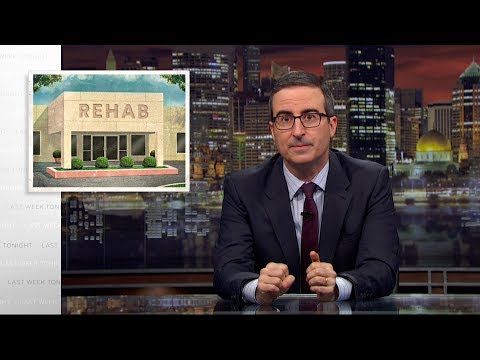

In [12]:
#@title #### 1. data's source is:
#@markdown #John Oliver's Youtube Clip { vertical-output: true, display-mode: "form" }
#@markdown ###video tag_id is:
#@markdown ```hWQiXv0sn9Y```
from IPython.display import YouTubeVideo
YouTubeVideo('hWQiXv0sn9Y', width=600, height=400)

use to download and extract faces from youtube videos


```
df = download_youtube_video()
```



In [0]:
DOWNLOAD = False
if DOWNLOAD is True:
    # WARRING !! WARRING !! WARRING !! WARRING     
    assert False
    # ARE YOU SURE ???
    assert not DOWNLOAD    
    # WARRING !! WARRING !! WARRING !! WARRING
    assert False
    # ARE YOU SURE ???
    assert False    
    df = download_youtube_video()
    # ARE YOU SURE ???
    assert False    
    # WARRING !! WARRING !! WARRING !! WARRING

In [0]:
import tensorflow as tf
from tensorflow import keras 

from tensorflow.keras import layers, models, activations
from tensorflow.keras import backend as K
from tensorflow.keras import preprocessing

import numpy as np
import scipy as sp

In [0]:
import ast

df = pd.read_csv('/gdrive/My Drive/Senior/John/john.csv')

df['c_path'] = df['f'].apply(lambda f: f.split('$')[0]) 
df['f_path'] = df['f'].apply(lambda f: f.split('$')[1]) 

df.drop(['f'], axis=1, inplace=True)

def str_to_list(text):
    return list(ast.literal_eval(text))

In [0]:
df.set_index(['t'], inplace=True, drop=False)

In [17]:
#@title  { display-mode: "form" }
df[:10]

,t,c,bb,c_path,f_path
t,,,,,
140,140,"(-76.5, -78.5)","[157, 153, 157, 153]",/gdrive/My Drive/Senior/John/conditions/140.jpg,/gdrive/My Drive/Senior/John/targets/140.jpg
141,141,"(-77.0, -78.0)","[156, 154, 156, 154]",/gdrive/My Drive/Senior/John/conditions/141.jpg,/gdrive/My Drive/Senior/John/targets/141.jpg
142,142,"(-77.0, -78.5)","[157, 154, 157, 154]",/gdrive/My Drive/Senior/John/conditions/142.jpg,/gdrive/My Drive/Senior/John/targets/142.jpg
143,143,"(-77.0, -79.0)","[158, 154, 158, 154]",/gdrive/My Drive/Senior/John/conditions/143.jpg,/gdrive/My Drive/Senior/John/targets/143.jpg
144,144,"(-77.0, -78.5)","[157, 154, 157, 154]",/gdrive/My Drive/Senior/John/conditions/144.jpg,/gdrive/My Drive/Senior/John/targets/144.jpg
145,145,"(-76.5, -79.0)","[158, 153, 158, 153]",/gdrive/My Drive/Senior/John/conditions/145.jpg,/gdrive/My Drive/Senior/John/targets/145.jpg
146,146,"(-77.0, -80.0)","[160, 154, 160, 154]",/gdrive/My Drive/Senior/John/conditions/146.jpg,/gdrive/My Drive/Senior/John/targets/146.jpg
147,147,"(-77.5, -79.0)","[158, 155, 158, 155]",/gdrive/My Drive/Senior/John/conditions/147.jpg,/gdrive/My Drive/Senior/John/targets/147.jpg
148,148,"(-77.5, -77.5)","[155, 155, 155, 155]",/gdrive/My Drive/Senior/John/conditions/148.jpg,/gdrive/My Drive/Senior/John/targets/148.jpg


In [0]:
delta_t = np.diff(np.array(df.t), 1)
u_dt, s_dt = delta_t.mean(), delta_t.std()

In [0]:
centroids = np.array(list(map(str_to_list, list(df.c))), dtype=np.float32)
delta_c = np.diff(centroids, 1, axis=0)

u_dx, s_dx, u_dy, s_dy = delta_c[:,0].mean(), centroids[:,0].std(), delta_c[:,1].mean(), centroids[:,1].std()

In [0]:
bboxs = np.array(list(map(str_to_list, list(df.bb))), dtype=np.float32)
bboxs = bboxs[:,:2]
delta_b = np.diff(bboxs, 1, axis=0)

u_dw, s_dw, u_dh, s_dh = bboxs[:,0].std(), delta_b[:,0].std(), bboxs[:,1].std(), delta_b[:,1].std()

In [0]:
tsteps = list(df.t)

seq = [[]]
for t, i in zip(tsteps[1:-1], range(1, len(tsteps) - 1)):
    T = tsteps[i - 1]
    if abs(t - T ) == 1 and abs(delta_b[i][0]) < s_dw and abs(delta_b[i - 1][1]) < s_dh:
        seq[-1].append(t)
    elif abs(t - T) < 10 and abs(delta_b[i - 1][0]) < s_dw * abs(t - T)  and abs(delta_b[i - 1][1]) < s_dh * abs(t - T) and abs(delta_c[i - 1][0]) < s_dx * abs(t - T)  and abs(delta_c[i - 1][1]) < s_dy * abs(t - T):
        seq[-1].append(t)
    elif abs(t - T ) > 150 and len(seq[-1]) >= 30:
        seq.append([])       
sequences = seq        

In [0]:
TARGET_SHAPE = (128, 128, 3)
TARGET_BATCH = (1, TARGET_SHAPE[0], TARGET_SHAPE[1], 3)

In [0]:
Ci = layers.Input(batch_shape=TARGET_BATCH, name='genorator_condition_input')

genorator_Unet = []

encoder4x4 = layers.Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), activation='linear', padding='same')(Ci)
genorator_Unet.append(layers.UpSampling2D(interpolation='bilinear')(
    
    layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same')(encoder4x4)))

encoder4x4 = layers.Conv2D(filters=128, kernel_size=(4, 4), strides=(2, 2), activation='linear', padding='same')(encoder4x4)
genorator_Unet.append(layers.UpSampling2D(interpolation='bilinear')(
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same')(encoder4x4)))

encoder4x4 = layers.Conv2D(filters=256, kernel_size=(4, 4), strides=(2, 2), activation='linear', padding='same')(encoder4x4)
genorator_Unet.append(layers.UpSampling2D(interpolation='bilinear')(
    
    layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same')(encoder4x4)))

encoder4x4 = layers.Conv2D(filters=512, kernel_size=(4, 4), strides=(2, 2), activation='tanh', padding='same')(encoder4x4)
genorator_Unet.append(layers.UpSampling2D(interpolation='bilinear')(
    
    layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='linear', padding='same')(encoder4x4)))

encoder4x4 = layers.ConvLSTM2D(filters=512, kernel_size=(4, 4), strides=(1, 1), padding='same', stateful=True)(
    layers.Lambda(lambda m:K.expand_dims(m, 0))(encoder4x4))

encoder4x4 = layers.ConvLSTM2D(filters=512, kernel_size=(2, 2), strides=(1, 1), padding='same', stateful=True)(
    layers.Lambda(lambda m:K.expand_dims(m, 0))(encoder4x4))

encoder4x4 = layers.ConvLSTM2D(filters=512, kernel_size=(4, 4), strides=(1, 1), activation='tanh', padding='same', stateful=True)(
    layers.Lambda(lambda m:K.expand_dims(m, 0))(encoder4x4))

decoder4x4 = layers.concatenate([genorator_Unet[-1], layers.UpSampling2D(interpolation='bilinear')(encoder4x4)], axis=-1)
decoder4x4 = layers.Conv2D(filters=512, kernel_size=(4, 4), strides=(1, 1), activation='relu', padding='same')(decoder4x4)

decoder4x4 = layers.concatenate([genorator_Unet[-2], layers.UpSampling2D(interpolation='bilinear')(decoder4x4)], axis=-1)
decoder4x4 = layers.Conv2D(filters=256, kernel_size=(4, 4), strides=(1, 1), activation='relu', padding='same')(decoder4x4)

decoder4x4 = layers.concatenate([genorator_Unet[-3], layers.UpSampling2D(interpolation='bilinear')(decoder4x4)], axis=-1)
decoder4x4 = layers.Conv2D(filters=128, kernel_size=(4, 4), strides=(1, 1), activation='relu', padding='same')(decoder4x4)

decoder4x4 = layers.concatenate([genorator_Unet[-4], layers.UpSampling2D(interpolation='bilinear')(decoder4x4)], axis=-1)
decoder4x4 = layers.Conv2D(filters=64, kernel_size=(4, 4), strides=(1, 1), activation='relu', padding='same')(decoder4x4)

decoder4x4 = layers.Conv2D(filters=3, kernel_size=(4, 4), strides=(1, 1),
                           activation='tanh', padding='same')(decoder4x4)

genorator_graph = decoder4x4
genorator = models.Model(inputs=[Ci], outputs=[decoder4x4], name='genorator')

In [0]:
_ = genorator.predict_on_batch([np.zeros(TARGET_BATCH)])

In [25]:
genorator.summary()

Model: "genorator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
genorator_condition_input (Inpu [(1, 128, 128, 3)]   0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (1, 64, 64, 64)      3136        genorator_condition_input[0][0]  
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (1, 32, 32, 128)     131200      conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (1, 16, 16, 256)     524544      conv2d_2[0][0]                   
__________________________________________________________________________________________

In [0]:
def get_spatial(concat):
    cnn4x4 = layers.Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2),
                           padding='same', activation='relu')(concat)
    cnn4x4 = layers.MaxPool2D()(cnn4x4)
    cnn4x4 = layers.Conv2D(filters=128, kernel_size=(4, 4), strides=(2, 2),
                           padding='same', activation='relu')(cnn4x4)
    cnn4x4 = layers.MaxPool2D()(cnn4x4)
    cnn4x4 = layers.Conv2D(filters=256, kernel_size=(4, 4), strides=(2, 2),
                           padding='same', activation='relu')(cnn4x4)
    cnn4x4 = layers.MaxPool2D()(cnn4x4)
    cnn4x4 = layers.Conv2D(filters=512, kernel_size=(4, 4), strides=(2, 2),
                           padding='same', activation='relu')(cnn4x4)
    
    
    cnn8x8 = layers.Conv2D(filters=64, kernel_size=(8, 8), strides=(4, 4),
                           padding='same', activation='relu')(concat)
    cnn8x8 = layers.MaxPool2D()(cnn8x8)
    cnn8x8 = layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(4, 4),
                           padding='same', activation='relu')(cnn8x8)
    cnn8x8 = layers.MaxPool2D()(cnn8x8)
    cnn8x8 = layers.Conv2D(filters=256, kernel_size=(4, 4), strides=(2, 2),
                           padding='same', activation='relu')(cnn8x8)  
    
    
    cnn16x16 = layers.Conv2D(filters=64, kernel_size=(16, 16), strides=(8, 8),
                           padding='same', activation='relu')(concat)
    cnn16x16 = layers.MaxPool2D()(cnn16x16)
    cnn16x16 = layers.Conv2D(filters=128, kernel_size=(16, 16), strides=(8, 8),
                           padding='same', activation='relu')(cnn16x16)
        
    cnnXxX = layers.Conv2D(filters=512, kernel_size=(1, 1), padding='same', activation='relu')(
        layers.concatenate([cnn16x16, cnn8x8, cnn4x4], axis=-1))
    
    cnnXxX = layers.Conv2D(filters=512, kernel_size=(1, 1), padding='same', activation='relu')(cnnXxX)
    
    dense = layers.Dense(units=256, activation='relu')(layers.GlobalAveragePooling2D()(cnnXxX))
    dense = layers.Dropout(0.15)(dense)

    dense = layers.Dense(units=128, activation='relu')(dense)
    dense = layers.Dropout(0.15)(dense)
    
    return layers.Dense(units=1, activation='sigmoid', name='spatial_out')(dense)


def get_temporal(concat):
    cnn4x4 = layers.ConvLSTM2D(filters=64, kernel_size=(8, 8), strides=(4, 4), stateful=True, return_sequences=True,
                           padding='same', activation='tanh')(concat)
    
    cnn4x4 = layers.ConvLSTM2D(filters=128, kernel_size=(8, 8), strides=(4, 4), stateful=True, return_sequences=True,
                           padding='same', activation='tanh')(cnn4x4)
    
    cnn4x4 = layers.ConvLSTM2D(filters=256, kernel_size=(8, 8), strides=(4, 4), stateful=True, return_sequences=False,
                           padding='same', activation='tanh')(cnn4x4)
    
    cnn4x4 = layers.Conv2D(filters=512, kernel_size=(4, 4), strides=(2, 2),
                           padding='same', activation='linear')(cnn4x4)
        
    cnn4x4 = layers.Dense(units=256, activation='linear')(layers.Flatten()(cnn4x4)) 
    
    cnn4x4 = layers.Dense(units=64, activation='linear')(cnn4x4)
    
    return layers.Dense(units=1, activation='sigmoid', name='termporal_out')(cnn4x4)

discriminator_input_spatial = [
    layers.Input((TARGET_SHAPE[0], TARGET_SHAPE[1], 3,), name='spatial_target_input'), 
    layers.Input((TARGET_SHAPE[0], TARGET_SHAPE[1], 3,), name='spatial_condition_input')]

discriminator_input_temporal = [
    layers.Input(batch_shape=(1, TARGET_SHAPE[0], TARGET_SHAPE[1], 3), name='temporal_target_input'), 
    layers.Input(batch_shape=(1, TARGET_SHAPE[0], TARGET_SHAPE[1], 3), name='temporal_condition_input')]

In [0]:
concat_saptial = layers.concatenate(discriminator_input_spatial, axis=-1)

concat_graph = get_spatial(concat_saptial)
spatial_dicrimenitor = models.Model(inputs=discriminator_input_spatial,
                                    outputs=[concat_graph], name='spatial_dicrimenitor')

In [0]:
concat_temporal = layers.Lambda(lambda m: K.expand_dims(m, 1))(
    layers.concatenate(discriminator_input_temporal, axis=-1))

temporal_graph = get_temporal(concat_temporal)
temporal_dicrimenitor = models.Model(inputs=discriminator_input_temporal,
                                     outputs=[temporal_graph], name='temporal_dicrimenitor')

In [29]:
spatial_dicrimenitor.summary()

Model: "spatial_dicrimenitor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
spatial_target_input (InputLaye [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
spatial_condition_input (InputL [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 128, 128, 6)  0           spatial_target_input[0][0]       
                                                                 spatial_condition_input[0][0]    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 64, 64, 64)   6208        concatenate_4[

In [30]:
temporal_dicrimenitor.summary()

Model: "temporal_dicrimenitor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
temporal_target_input (InputLay [(1, 128, 128, 3)]   0                                            
__________________________________________________________________________________________________
temporal_condition_input (Input [(1, 128, 128, 3)]   0                                            
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (1, 128, 128, 6)     0           temporal_target_input[0][0]      
                                                                 temporal_condition_input[0][0]   
__________________________________________________________________________________________________
lambda_3 (Lambda)               (1, 1, 128, 128, 6)  0           concatenate_6

In [0]:
input_condition = layers.Input(batch_shape=TARGET_BATCH, name='adversial_condition_input')

FakeTarget = genorator([input_condition])

spatial_score = spatial_dicrimenitor({'spatial_target_input': FakeTarget, 'spatial_condition_input':input_condition})
temporal_score = temporal_dicrimenitor({'temporal_target_input': FakeTarget, 'temporal_condition_input':input_condition})

combined = models.Model(inputs=[input_condition], outputs=[spatial_score, temporal_score, FakeTarget], name='adversial_model')

In [0]:
def step_temporal(condition, target, temporal_model=temporal_dicrimenitor):
    assert abs(temporal_model.train_on_batch(x={'temporal_target_input': condition, 'temporal_condition_input':target}, y=[np.zeros((1, 1))],
                                         sample_weight=np.array([0]))[0] - 1e-6) < 1e-5

def step_combined(condition, combined_model=combined,  temporal_model=temporal_dicrimenitor, spatial_model=spatial_dicrimenitor):    
    if spatial_model.trainable:
        spatial_model.trainable = False
        
    if temporal_model.trainable:
        temporal_model.trainable = False
        
    assert abs(sum(combined_model.train_on_batch(x={'adversial_condition_input': condition}, y=[np.zeros((1, 1)), np.zeros((1, 1)), condition],
                                         sample_weight=[np.array([0]), np.array([0]), np.array([0])])[:3]) - 1e-6) < 1e-5

def reset(combined_model=combined, temporal_model=temporal_dicrimenitor):
    genorator.reset_states(); combined.reset_states()    
    temporal_dicrimenitor.reset_states()

In [0]:
combined_optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4, momentum=0.8)
combined.compile(loss={'spatial_dicrimenitor': 'binary_crossentropy',
                       'temporal_dicrimenitor': 'binary_crossentropy',
                       'genorator': 'mae'},
                 
                 metrics={'spatial_dicrimenitor':'accuracy',
                          'temporal_dicrimenitor':'accuracy'},
                 
                 loss_weights={'spatial_dicrimenitor': 1.0,
                               'temporal_dicrimenitor': 1.0,
                               'genorator': 10.0},
                 
                 optimizer=combined_optimizer)

temporal_optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4, momentum=0.8)
temporal_dicrimenitor.compile(loss={'termporal_out': 'mse'},
                           
                  metrics={'termporal_out':'accuracy'},
                              
                  optimizer=temporal_optimizer)

spatial_optimizer = tf.keras.optimizers.Adam(learning_rate=4 * 1e-4)
spatial_dicrimenitor.compile(loss={'spatial_out': 'binary_crossentropy'},
                           
                  metrics={'spatial_out':'accuracy'},
                             
                  optimizer=spatial_optimizer)

In [34]:
combined.summary()

Model: "adversial_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
adversial_condition_input (Inpu [(1, 128, 128, 3)]   0                                            
__________________________________________________________________________________________________
genorator (Model)               (1, 128, 128, 3)     89563491    adversial_condition_input[0][0]  
__________________________________________________________________________________________________
spatial_dicrimenitor (Model)    multiple             6915137     adversial_condition_input[0][0]  
                                                                 genorator[1][0]                  
__________________________________________________________________________________________________
temporal_dicrimenitor (Model)   (1, 1)               34851457    adversial_condition

In [35]:
#@title Training Parameters
#@markdown config is saved in `/gdrive/My Drive/Senior/config.js`
class config:
    params = {
        'epochs':{ 'max': 22, 'cur': 0},    
        'lr':{
            't': 1e-4,
            's': 1e-4,
            'g': 1e-4
        }
        
        ,'loss':{
            'g': [],
            's': [],
            't': []
        }
        , 'seq_lenght': 96
        , 'seq_inc': 48
    }
    
    def load(file_path='/gdrive/My Drive/Senior/config.js'):
        with open(file_path, 'r') as f:
            config.params = json.loads(f.read())
    
    def save(file_path='/gdrive/My Drive/Senior/config.js'):
        with open(file_path, 'w') as f:
            f.write(json.dumps(config.params))        
            
display(config.params)

{'epochs': {'cur': 0, 'max': 22},
 'loss': {'g': [], 's': [], 't': []},
 'lr': {'g': 0.0001, 's': 0.0001, 't': 0.0001},
 'seq_inc': 48,
 'seq_lenght': 96}

In [0]:
def _read_condition(t, ndim=0):
    f_path = df.loc[t].c_path
    return np.expand_dims(cv2.resize(cv2.imread(f_path), TARGET_SHAPE[:2]).astype(np.float32) / 255, axis=ndim)
        
def _read_target(t, ndim=0):
    f_path = df.loc[t].f_path
    return np.expand_dims((cv2.resize(cv2.imread(f_path), TARGET_SHAPE[:2]).astype(np.float32) / 255 - 0.5) * 2, axis=ndim)

def getIndex(t, ndim=0):
    return _read_condition(t, ndim), _read_target(t, ndim)

In [0]:
def get_interval(n, dsize=128):
    interval = 0
    while interval < dsize:
        start_index = rand.randint(a= int(n* 0.20), b=int(n * 0.80))
        end_index = rand.randint(a=start_index, b=min([n, dsize + start_index]))
        interval = end_index - start_index
        
    prepare_index = rand.randint(max([start_index - int(dsize / 2), 0]), start_index - 1)
    return prepare_index, start_index, end_index

In [0]:
_PLOTING_SAMPLES = [[], 0]
_PLOTING_FREQ = 4

def extra_loging(a=1.0, msg='Progress'):
    if time.time() - _PLOTING_SAMPLES[1] < _PLOTING_FREQ:
        return False
    
    _PLOTING_SAMPLES[1] = time.time() 
    
    update_progress(a, msg)
    print('epoch', config.params['epochs']['cur'],
              'of', config.params['epochs']['max'])
    
    if len(config.params['loss']['g']) > 0:
        try:
            print('spatial_info:\t',
                  config.params['loss']['s'][-1])
            
            print('temporal_info:\t',
                  np.array(config.params['loss']['t'][-1]).mean(axis=1), '\n')
            
            print('adversial_info:\t',
                  np.array(config.params['loss']['g'][-1]).mean(axis=1), '\n\n')
        except Exception as e:
            _ = None
    
    if len(_PLOTING_SAMPLES[0]) < 1:
        return False
    
    imshowGrid(_PLOTING_SAMPLES[0], dgrid_shape=(1, 4))
    imshowGrid(_PLOTING_SAMPLES[0][-4:], dgrid_shape=(1, 4))

    imshowGrid(_PLOTING_SAMPLES[0][:8], dgrid_shape=(2, 4))
    imshowGrid(_PLOTING_SAMPLES[0][-8:], dgrid_shape=(2, 4))

In [0]:
from sklearn import model_selection

def train_spatial(state_seq, train_seq, drop_rate=0.35):
    p_counter = 0
    
    spatial_dicrimenitor.trainable = True
     
        
    for t in state_seq:
        p_counter += 1
        
        extra_loging(p_counter / (len(state_seq) + len(train_seq)), msg='train_spatial_warming')
        
        _ = genorator.predict(_read_condition(t))
        
    
    VALIDS, FAKES, CONDITIONS = [[], [], []]
    for t in train_seq:        
        p_counter += 1
        
        extra_loging(p_counter / (len(state_seq) + len(train_seq)), msg='train_spatial_training')
        
        if rand.randint(a=0, b=100) < drop_rate * 100:
            _ = genorator.predict(_read_condition(t))
            continue
            
        valid, condition = getIndex(t)

        VALIDS.append(valid[0])
        FAKES.append(genorator.predict({'genorator_condition_input': _read_condition(t)})[0])        
        
        CONDITIONS.append(condition[0])

    _PLOTING_SAMPLES[0] = FAKES
    f_train, _, c_train, _, y_train, _ = model_selection.train_test_split(np.append(VALIDS, FAKES, axis=0),
                                                              np.append(CONDITIONS, CONDITIONS, axis=0),
                                                              np.append(np.ones((1, len(FAKES))), np.zeros((1, len(FAKES)))),
                                                                               test_size=0.0)    
    extra_loging(p_counter / (len(state_seq) + len(train_seq)), msg='train_spatial_training')    
    return spatial_dicrimenitor.train_on_batch(x={'spatial_target_input': f_train, 'spatial_condition_input':c_train},
                                               y={'spatial_out': y_train})

def train_temporal(state_seq, train_seq, drop_rate=0.15):
    p_counter = 0
    
    temporal_dicrimenitor.trainable = True
    loss = []
    
    for t in state_seq:
        extra_loging(p_counter / (len(state_seq) + len(train_seq)), msg='train_temporal_warming')
        
        p_counter += 1
        
        valid, condition = getIndex(t)            
        step_temporal(valid, condition)
    
    STEPER = 0    
    da, dv, y  = 0.0, 0.0, 1.0
    for t in train_seq:              
        extra_loging(p_counter / (len(state_seq) + len(train_seq)), msg='train_temporal_training')
        
        p_counter += 1
        
        STEPER += 1
        if rand.randint(a=0, b=100) < 0.20 * 100 and STEPER > 1:
            da = min([0.05, da + 0.05])
            dv = min([0.75, dv + 0.25])
            continue 
            
        y = max([min([y + 0.25, 1.0]) - dv, 0.0])
        
        dv = min([max([dv + da - 0.15, 0.0]), 0.75])
        da = min([max([da - 0.15, 0.0]), 0.75])
    
        if rand.randint(a=0, b=100) < drop_rate * 100:
            valid, condition = getIndex(t)            
            step_temporal(valid, condition)            
            continue
                
        valid, condition = getIndex(t)  
        loss.append(temporal_dicrimenitor.train_on_batch(
            x={'temporal_target_input': valid, 'temporal_condition_input': condition},
            y={'termporal_out': np.array([[y]])},
            sample_weight=np.array([1 + y ** 2])))
        
    return loss
        
def train_adversial(state_seq, train_seq, drop_rate=0.20):
    p_counter = 0
    
    temporal_dicrimenitor.trainable = False
    spatial_dicrimenitor.trainable = False
    
    loss = []
    
    for t in state_seq:   
        extra_loging(p_counter / (len(state_seq) + len(train_seq)), msg='train_adversial_warming')
        
        p_counter += 1
        
        step_combined(_read_condition(t))
    
    for t in train_seq:
        extra_loging(p_counter / (len(state_seq) + len(train_seq)), msg='train_adversial_training')
        
        p_counter += 1
        
        if rand.randint(a=0, b=100) < drop_rate * 100:
            step_combined(_read_condition(t))            
            continue
            
        valid, condition = getIndex(t)
        loss.append(combined.train_on_batch(x={'adversial_condition_input': condition},
                                                  y=[np.ones((1, 1)), np.ones((1, 1)), valid]))
    return loss             

train_adversial_training: [###############-----] 74.8%
epoch 0 of 22


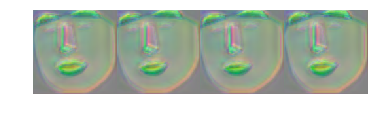

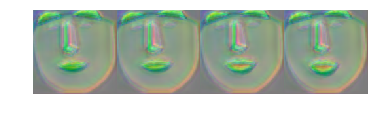

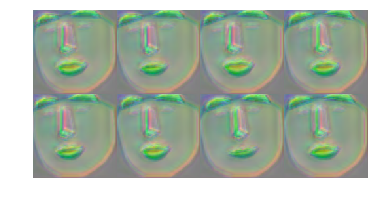

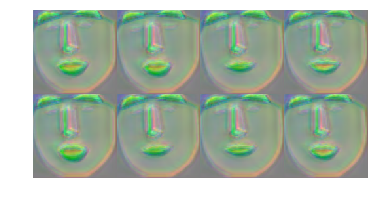

In [0]:

temporal_dicrimenitor, spatial_dicrimenitor
while config.params['epochs']['cur'] <  config.params['epochs']['max']:    
    seq_indexes = [i for i in range(len(sequences))];rand.shuffle(seq_indexes)
    for seq in [sequences[seq_i] for seq_i in seq_indexes]:        
        _step_timer = time.time()
        
        temporal_dicrimenitor.trainable = True
        spatial_dicrimenitor.trainable = True
        
    # NOTE: reseting states...       
        reset()
        
        prepare_index, start_index, end_index = get_interval(len(seq), dsize=config.params['seq_lenght'])
        config.params['loss']['s'].append(train_spatial(seq[prepare_index:start_index], seq[start_index:end_index]))
        
    # NOTE: reseting states...
        reset()
        
        prepare_index, start_index, end_index = get_interval(len(seq), dsize=config.params['seq_lenght'])
        config.params['loss']['t'].append(train_temporal(seq[prepare_index:start_index], seq[start_index:end_index]))
                
    # NOTE: reseting states...
        reset()
        
        temporal_dicrimenitor.trainable = False
        spatial_dicrimenitor.trainable = False
        
        prepare_index, start_index, end_index = get_interval(len(seq), dsize=config.params['seq_lenght'])
        config.params['loss']['g'].append(train_adversial(seq[prepare_index:start_index], seq[start_index:end_index]))
        
   # NOTE: logging states...    

        config.save(file_path='/gdrive/My Drive/Senior/config.js')            
        output.clear(wait=True)
        
        print('epoch', config.params['epochs']['cur'],
              'of', config.params['epochs']['max'])
        print('last step took:\t',
              time.time() - _step_timer, '\n\n')
        
        print('spatial_info:\t',
              config.params['loss']['s'][-1])
        print('temporal_info:\t',
              np.array(config.params['loss']['t'][-1]).mean(axis=1), '\n')
        print('adversial_info:\t',
              np.array(config.params['loss']['g'][-1]).mean(axis=1), '\n\n')

        imshowGrid(_PLOTING_SAMPLES[0], dgrid_shape=(1, 4))
        imshowGrid(_PLOTING_SAMPLES[0][-4:], dgrid_shape=(1, 4))
        
        imshowGrid(_PLOTING_SAMPLES[0][:8], dgrid_shape=(2, 4))
        imshowGrid(_PLOTING_SAMPLES[0][-8:], dgrid_shape=(2, 4))
        
        _PLOTING_SAMPLES[0] = []
        
    combined.save('/gdrive/My Drive/Senior/com.h5')
    genorator.save('/gdrive/My Drive/Senior/gen.h5')
    
    temporal_dicrimenitor.save('/gdrive/My Drive/Senior/t_dis.h5', include_optimizer=True)
    spatial_dicrimenitor.save('/gdrive/My Drive/Senior/s_dis.h5', include_optimizer=True)
        
    config.params['seq_lenght'] = config.params['seq_lenght'] + config.params['seq_inc']
    config.params['epochs']['cur'] = config.params['epochs']['cur'] + 1
    
    config.save(file_path='/gdrive/My Drive/Senior/config.js')

In [0]:
def export(seq):
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter('/gdrive/My Drive/Senior/output.mp4', fourcc, 30.0, (128,128))

    genorator.reset_states()

    for t in seq:
        condition = cv2.imread(df.loc[t].c_path)

        condition = cv2.resize(condition, (TARGET_SHAPE[0], TARGET_SHAPE[1]))

        condition = condition.astype(np.float32)

        condition = condition / 255

        img = genorator.predict_on_batch(np.array([condition]).astype(np.float32))
        img = ((img + 1) / 2 * 255).astype(np.uint8)

        out.write(img[0])

    out.release()